In [10]:
%run ./setup_notebook.ipynb

In [2]:
import numpy as np # linear algebra
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
# from plotly.subplots import make_subplot
from geopy.geocoders import Nominatim
from skimage import io
# import ipywidgets as widgets
import re
from ipywidgets import interact, interact_manual
import folium
import time

<div style="font-family:'Trebuchet MS', 'Impact', sans-serif; 
            margin-bottom: 20px; letter-spacing: 6px; text-align:center;
            font-size: 200%;"><b>University of Toronto ECE2T2 Class Profile</b></div>

<div style="font-size: 16px;text-align:center;"><i>Number of Respondents: 52</i></div>

<p style="text-align:start;">Welcome to the University of Toronto ECE2T2 Class Profile -- Inspired by Waterloo Software Engineering 2021 Class Profile. 
We come here to give you all the deets, all the information on our graduating class: their passions, compassions, and the future they have built in their times at UofT.
   
Let's find out about who these 52 people of University of Toronto ECE2T2 are, and where they be at!</p>

In [3]:
df = pd.read_csv("Electrical_and_Computer_Engineering_2023_-_Class_Profile_Survey_Submissions_2023-03-29.csv")

In [4]:
print(len(df))
df.head(5)

52


,Submission ID,Respondent ID,Submitted at,What program were you in first year?,What program are you in now?,What 2 areas did you specialize in?,What 2 areas did you specialize in? (Area 1: Photonics & Semiconductor Physics),What 2 areas did you specialize in? (Area 2: Electromagnetics & Energy Systems),What 2 areas did you specialize in? (Area 3: Digital & Analog Electronics),"What 2 areas did you specialize in? (Area 4: Systems Control, Communications & Signal Processing)",...,Which of the following have you done during university? (Kissed someone romantically),Which of the following have you done during university? (Been in a committed relationship),Which of the following have you done during university? (Been in a long distance relationship),Which of the following have you done during university? (Had 'friends with benefits'),Which of the following have you done during university? (Used a dating app),List the recreational controlled substances you have used during university,Untitled long answer field (1),Untitled long answer field (2),Untitled long answer field (3),How many sexual partners have you had
0,qaRxpG,VpyqOy,2023-02-21 01:01:21,Computer,Computer,"Area 5: Computer Hardware & Computer Networks,...",False,False,False,False,...,False,False,False,False,True,NaN,Interesting to see myself - as a person who kn...,Maybe not doing enough design teams and not sp...,Hope for the best for everyone 🙂,0.0
1,07e206,J1YGy4,2023-02-21 01:10:02,Electrical,Electrical,"Area 6: Computer Software, Area 4: Systems Con...",False,False,False,True,...,NaN,NaN,NaN,NaN,NaN,Cannabis,The pandemic allowed me to realize I did not h...,I wish I had learned to focus on my own person...,Do not lose the person that you are in spite o...,0.0
2,E5xj2L,kbxgVM,2023-02-21 01:18:09,TrackOne,Computer,"Area 5: Computer Hardware & Computer Networks,...",False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,Cannabis,NaN,NaN,Live long and prosper,0.0
3,PDOjb0,9N5avV,2023-02-21 01:53:57,TrackOne,Electrical,"Area 1: Photonics & Semiconductor Physics, Are...",True,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,Celebrating my birthday with my U of T friends:),Not playing intramurals and going to more soci...,Find joy in simple things:),NaN
4,9XQGoK,6D59QJ,2023-02-21 01:55:39,TrackOne,Computer,"Area 6: Computer Software, Area 5: Computer Ha...",False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning



In [202]:
## Write out columns to a text file for analysis
with open("all_columns.txt", mode="w", encoding="utf-8") as f:
    f.write("\n".join(df.columns))

In [203]:
# Modify column data, if they still exist
if {"Untitled long answer field (1)", "Untitled long answer field (2)", "Untitled long answer field (3)"}.issubset(df.columns):
  df.rename(columns={
                      "Untitled long answer field (1)" : "1. Share a story, happy or sad, from your time in ECE",
                      "Untitled long answer field (2)" : "2. What is something you regret over your time at UofT?",
                      "Untitled long answer field (3)" : "3. Give a piece of advice to your fellow ECE 2T2 - 2023 grads"
                    }, inplace=True)

  # Check column data has indeed been changed
  index = df.columns.str.contains("1. Share a story, happy or sad, from your time in ECE") | \
  df.columns.str.contains("2. What is something you regret over your time at UofT?") | \
  df.columns.str.contains("3. Give a piece of advice to your fellow ECE 2T2 - 2023 grads")

  indices = df.columns[index]
  assert len(indices) == 3

In [204]:
# Drop unnecessary article. Non-useful data.
# Proof that all data under this column are null
if "https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-ameri" + \
          "can-economic-class-system" in df.columns:
        assert df["https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-ameri"
                "can-economic-class-system"].isna().sum() == len(df)

        df.drop("https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system", 
                axis=1, inplace=True)

## Data Exploration

# Class Profile

## What Program Were You in First Year?

In [8]:
# TO-DO! Make trace subplots with this
fig = px.pie(df, names="What program were you in first year?", color="What program were you in first year?")
fig.update_traces(textinfo="label+percent",
                  hovertemplate="<b>%{label}</b><br><i>Count</i>: %{value}")
fig.show()

## What Program Are You in Now?

In [9]:
fig = px.pie(df, names="What program are you in now?", color="What program are you in now?")
fig.update_traces(textinfo="label+percent",
                  hovertemplate="<b>%{label}</b><br><i>Count</i>: %{value}")
fig.show()

## What 2 Areas Did You Specialize In?

In [10]:
# Sort specialized areas to remove duplicates. (Ex. Area 6 + Area 5 is equivalent to Area 5 + Area 6)
df["What 2 areas did you specialize in?"] = remove_redundancy(df["What 2 areas did you specialize in?"]) 

In [11]:
df_specialization = df.loc[:, ["What 2 areas did you specialize in?"]]
df_specialization.sort_values("What 2 areas did you specialize in?", ascending=False, inplace=True)

# hover text
areas_long_form = df_specialization["What 2 areas did you specialize in?"].str.split(", ").map(lambda x: " + ".join(x)).tolist()

# Simplified areas
areas_simplified = df_specialization["What 2 areas did you specialize in?"].map(
    lambda word: " + ".join(re.findall('(Area.*?):', word))
)

df_specialization["What 2 areas did you specialize in?"] = areas_simplified




In [12]:
# df.groupby("What 2 areas did you specialize in?", as_index=False).count()[["What 2 areas did you specialize in?", "Submission ID"]]
fig = px.pie(df_specialization, names="What 2 areas did you specialize in?", color="What 2 areas did you specialize in?")
fig.update_traces(textinfo="label+percent",
                  hovertemplate="%{text}<br><i>Count:</i> %{value}<br> %{percent}",
                  hovertext=areas_long_form,
                  text=areas_simplified)
fig.update_layout(legend_traceorder="reversed")
fig.show()

## Other Profile Information (Gender, Sexual Orientation, Domestic/International, Ethnicities)

In [13]:
# data_checker(df["Are you a domestic or international student?"], check_unique=True)

In [24]:
# data_checker(df["What are your Ethnicities?"], check_unique=True)

In [26]:
df["What are your Ethnicities?"].fillna("Did not wish to disclose", inplace=True)

In [14]:
df["Are you a domestic or international student?"].fillna("Did not wish to disclose", inplace=True)

In [28]:
# df["Are you a domestic or international student?"].unique()

In [168]:
fig = create_figure_with_dropdown(df,
                                  options=["What is your gender?", "Are you a domestic or international student?",
                                           "What is your sexual orientation?", "What are your Ethnicities?"])
fig.update_layout(showlegend=False)
fig.show()

In [46]:
# data_checker(df["Do you identify as an Indigenous person, that is, First Nations, Metis, or Inuk (Inuit)?"], check_unique=True)

In [51]:
fig = create_table(df,
                  "Do you identify as an Indigenous person, that is, First Nations, Metis, or Inuk (Inuit)?")
fig.update_layout(height=400)
fig.show()

# Location Profile!

## Childhood, Sweet Childhood~

Where did 4th Year ECEs attend high school?

In [40]:
# data_checker(df_high_school, check_unique=True)

In [41]:
df_high_school = df.loc[df["Where did you attend high school?"].notna(), "Where did you attend high school?"]

In [44]:
geolocator = Nominatim(user_agent="app")

In [11]:
## Hard Code Unique Locations
identified_high_school_locs = \
 [geolocator.geocode(query=dict(country="China")), geolocator.geocode(query=dict(country="Canada", city="Toronto")),
 geolocator.geocode(query=dict(country="Canada", state="British Columbia")),
 geolocator.geocode(query=dict(country="Nicaragua")), # Central America
 geolocator.geocode(query="London, Ontario"), # Southern Ontario
 geolocator.geocode(query="USA")]

In [45]:
identified_high_school_coordinates = [(location.latitude, location.longitude) for location in identified_high_school_locs]

In [46]:
df_high_school_merged = map_location_setup(df_high_school, identified_high_school_coordinates)

In [47]:
# df_high_school_merged

,Coordinates,Where did you attend high school?
Asia,"(35.000074, 104.999927)",9
GTA,"(43.6534733, -79.383961)",24
West Coast of Canada,"(55.001251, -125.002441)",7
Americas,"(12.6090157, -85.2936911)",1
Southern Ontario,"(42.9832406, -81.243372)",8
USA,"(39.7837304, -100.445882)",1


In [122]:
m = create_map()

In [124]:
for i in range(df_high_school_merged.shape[0]):
    current_data = df_high_school_merged.iloc[i]
    current_name = current_data.name
    number_per_name = current_data[df_high_school_merged.columns[1]]
    html = f'''
    <div style="display: flex; justify-content: left; flex-direction: column;">
        <div style="padding:0 10px 10px 0;color:grey"><b>{current_name}</b></div>
        <div style="padding:0 10px 10px 0;font-size:40;font-weight:100;text-align:center">{number_per_name}</div>
        <div style="text-align:center;padding:0 10px 0 0;">{"students studied high school here!"}</div>
    </div>
    '''
    coordinates = current_data["Coordinates"]
    coordinates = (coordinates[0] + np.random.rand() + 0.5,
                   coordinates[1] + np.random.rand() + 0.5)
    
    iframe = folium.IFrame(html=html, width=170, height=170)
    icon = folium.Icon(icon="school", color='lightblue', prefix='fa')
    popup = folium.Popup(iframe)
    folium.Marker(location=coordinates, popup=popup, icon=icon).add_to(m)
    # print()

Where are their homes?

In [107]:
# data_checker(df['Where is home? '], check_unique=True)

In [108]:
df_home = df['Where is home? '].dropna()

In [109]:
# data_checker(df_home, check_unique=True)

In [110]:
geolocator = Nominatim(user_agent="app")

In [111]:
## Hard Code Unique Locations
identified_home_locs = \
 [geolocator.geocode(query=dict(country="South Korea")), geolocator.geocode(query=dict(country="Canada", state="Saskatchewan")),
 geolocator.geocode(query=dict(country="China", city="Hong Kong")),
 geolocator.geocode(query=dict(country="Egypt")),
 geolocator.geocode(query=dict(country="Canada", state="British Columbia")),
 geolocator.geocode(query=dict(country="Canada", city="Toronto")),
 geolocator.geocode(query=dict(country="Canada", state="Saskatchewan")),
 geolocator.geocode(query=dict(country="India")),
 geolocator.geocode(query=dict(country="United Arab Emirates")),
 geolocator.geocode(query=dict(country="Brazil")),
 geolocator.geocode(query=dict(country="Bangladesh")),
 geolocator.geocode(query=dict(country="USA")),
 geolocator.geocode(query=dict(country="Pakistan"))
 ]


In [112]:
identified_home_coordinates = [(location.latitude, location.longitude) for location in identified_home_locs]

In [113]:
df_home_merged = map_location_setup(df_home, identified_home_coordinates)

In [125]:
for i in range(df_home_merged.shape[0]):
    current_data = df_home_merged.iloc[i]
    current_name = current_data.name
    number_per_name = current_data[df_home_merged.columns[1]]
    html = f'''
    <div style="display: flex; justify-content: left; flex-direction: column;">
        <div style="padding:0 10px 10px 0;color:grey"><b>{current_name}</b></div>
        <div style="padding:0 10px 10px 0;font-size:40;font-weight:100;text-align:center">{number_per_name}</div>
        <div style="text-align:center;padding:0 10px 0 0;">{"students' homes are here!"}</div>
    </div>
    '''
    coordinates = current_data["Coordinates"]
    coordinates = (coordinates[0] + np.random.rand() + 0.5,
                   coordinates[1] + np.random.rand() + 0.5)
    
    iframe = folium.IFrame(html=html, width=170, height=170)
    icon = folium.Icon(icon="home", color='red', prefix='fa')
    popup = folium.Popup(iframe)
    folium.Marker(location=coordinates, popup=popup, icon=icon).add_to(m)
    # print()

In [128]:
get_figure_for_map(m, height=500)

# Family Info!

Who are the proud parents?

In [162]:
# data_checker(df["Did you or your parents immigrate to Canada?"], check_unique=True)
df["Did you or your parents immigrate to Canada?"].fillna("Did not say", inplace=True)


In [163]:
# data_checker(df["Was one of your parents born as a Canada Citizen?"], check_unique=True)
df["Was one of your parents born as a Canada Citizen?"].fillna("Did not say", inplace=True)

In [164]:
fig = create_table_with_dropdown(df, ["Did you or your parents immigrate to Canada?",
                                "Was one of your parents born as a Canada Citizen?"])
fig.show()

In [165]:
# data_checker(df["Education Level of Parents"], check_unique=True)
df["Education Level of Parents"].fillna("Did not say", inplace=True)

In [166]:
# data_checker(df["Family Income Before UofT"], check_unique=True)
df["Family Income Before UofT"].fillna("Did not wish to disclose", inplace=True)

In [170]:
fig = px.histogram(df, x="Education Level of Parents", color="Education Level of Parents")
fig.show()

In [173]:
# data_checker(df["Family Income Before UofT"], check_unique=True)
fig = px.histogram(df, x="Family Income Before UofT", color="Family Income Before UofT")
fig.update_xaxes(categoryorder='array', categoryarray= ['32,048 or less', '$32,048 - $53,413',
                                                        '$53,413 - $106,827', '$106,827 - $373,894',
                                                        '$373,894 and up', 'Did not wish to disclose'])
fig.update_layout(showlegend=False)
fig.show()

## Language Spoken at Home?

We are a diverse group, UofT ECEs!

In [11]:
df = df.rename({"What languages do you speak at home? (If more than 1, please section by a comma. ie English, Italian, French)":
            "What languages do you speak at home?"}, axis=1)

In [12]:
# data_checker(df["What languages do you speak at home?"], check_unique=True)

In [13]:
language_at_home = df["What languages do you speak at home?"].dropna()
language_at_home=language_at_home.str.lower()
language_at_home=language_at_home.str.replace(r'[-./?!,":;()\']', '', regex=True)

In [14]:
generate_word_map(language_at_home, file_path="embed_images/Language_WordCloud.png", width=1000, height=600)


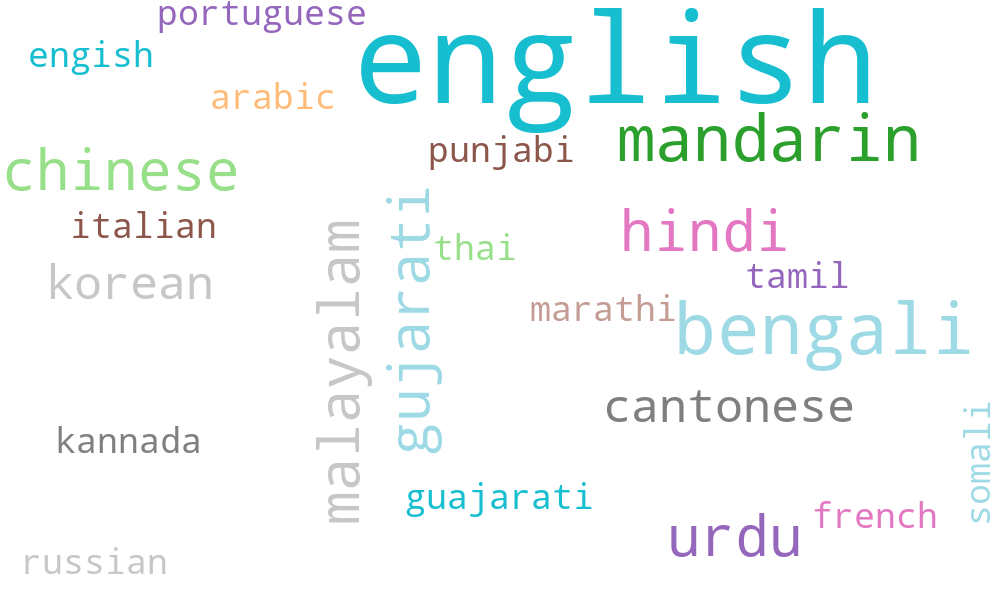

In [15]:
img = io.imread('./embed_images/Language_WordCloud.png')
fig = px.imshow(img, binary_compression_level=0)
fig.update_layout(xaxis={'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        yaxis={'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        margin=dict(autoexpand=False, b=0, l=0, r=0, t=0))
fig.show()

## How Many Percentage of ECE2T2 Students Share the Same Religion as Their Parents? 

In [ ]:
# data_checker(df["What is your religious affiliation?"], check_unique=True)
df["What is your religious affiliation?"].fillna("Did not disclose", inplace=True)

KeyError: 'What is your religious affiliation?'

In [ ]:
# data_checker(df["What is the religious affiliation of your parent(s)?"], check_unique=True)
df["What is the religious affiliation of your parent(s)?"].fillna("Did not say", inplace=True)

In [ ]:
series_is_same_religion = df["What is your religious affiliation?"] == df["What is the religious affiliation of your parent(s)?"]

In [ ]:
series_is_same_religion.replace({False: "no", True: "yes"}, inplace=True)

In [ ]:
fig = px.pie(names=series_is_same_religion, color=series_is_same_religion)
fig.update_traces(textinfo="label+percent",
                  hovertemplate="<b>%{label}</b><br><i>Count</i>: %{value}")
fig.show()

## What are the Religious Pairings if Child and Parent Share Different Religions? Same Religions?

Religious Pairing is written in the format of *student_religion*, *parent_reigion*

In [ ]:
df_combined_religion = df.loc[:, ["What is your religious affiliation?", "What is the religious affiliation of your parent(s)?"]]

In [ ]:
df_combined_religion["Student+Parent_Combined_Religion"] = df["What is your religious affiliation?"] + ", " + df["What is the religious affiliation of your parent(s)?"]

In [ ]:
df_combined_religion.loc[df_combined_religion["What is your religious affiliation?"] == \
                                df["What is the religious affiliation of your parent(s)?"], 
                                "Student+Parent_Combined_Religion"] = \
                                df_combined_religion.loc[df_combined_religion["What is your religious affiliation?"] == \
                                df["What is the religious affiliation of your parent(s)?"], 
                                "Student+Parent_Combined_Religion"].str.split(", ").str[0].str.strip()
                                    

In [ ]:
fig = create_figure_with_dropdown(df_combined_religion,
                            options=["Student+Parent_Combined_Religion", "Student+Parent_Combined_Religion"],
                            filters=[
                                df_combined_religion["What is your religious affiliation?"] == \
                                df["What is the religious affiliation of your parent(s)?"],
                                df["What is your religious affiliation?"] != \
                                df["What is the religious affiliation of your parent(s)?"]],
                            labels=["Same Religion", "Different Religion"],
                            sort_x=True,
)   
fig.update_layout(showlegend=False)
fig.update_traces(hovertemplate="%{x}<br><i>Count</i>: %{y}")

fig.show()

# Professional Profile

The life we ECE2T2s lived as we chased after our boundless dreams

In [174]:
# data_checker(df["In what year did you start your university studies?"], check_unique=True)

Unique values [2018. 2019. 2017.   nan]
Number of NA Values: 1


## In What Year did ECE2T2s Start Their University Studies?

In [233]:
df_year_of_start_univ = df["In what year did you start your university studies?"].dropna().astype(int)
df_year_of_start_univ_cleaned = pd.DataFrame(df_year_of_start_univ.value_counts()).reset_index()

# print(df_year_of_start_univ_cleaned)
df_year_of_start_univ_cleaned.rename({"index" : "year",
                                     "In what year did you start your university studies?":
                                     "Number of Students"}, axis=1, inplace=True)
df_year_of_start_univ_cleaned.sort_values("year", ascending=True, inplace=True)
fig = px.line(df_year_of_start_univ_cleaned, x="year", y="Number of Students", 
        markers=True)

fig.update_traces(marker_size=[8, 18, 8])
fig.update_xaxes(
    dtick="Y1"
)
fig.show()

## What was your dream career as a kid?

In [ ]:
df["What was your dream career as kid?"].fillna("did not answer", inplace=True)

In [234]:
fig = create_table(df, "What was your dream career as kid?")
fig.update_layout(height=500)
fig.show()

## Top 5 Questions You Did Not Want to Answer

In [8]:
num_nulls = df.isna().sum()

# df_top_5_values_no_answers = num_nulls.sort_values(ascending=False)
df_top_5_values_with_no_answers = pd.DataFrame(num_nulls, columns=["Number of Non-Responses"]).reset_index()
df_top_5_values_with_no_answers.rename({"index" : "Question"}, axis=1, inplace=True)
df_top_5_values_with_no_answers["Percentage of Non-Responses"] = \
    (df_top_5_values_with_no_answers["Number of Non-Responses"] / len(df) * 100).round(2).astype(str) + "%"

df_top_5_values_with_no_answers.sort_values("Number of Non-Responses", ascending=False, inplace=True)
df_top_5_values_with_no_answers = df_top_5_values_with_no_answers.head(5)

In [9]:
# Write out num nulls to a file
obj = zip(num_nulls.index.tolist(), num_nulls.tolist())
nulls_list = list(obj)

with open("nulls.txt", mode="w", encoding="utf-8") as f:
    f.write("\n".join([f"{tup[0]}: {tup[1]}" for tup in nulls_list]))

In [14]:
fig = go.Figure(go.Table(
    header=dict(values=["Question", "No Response", "Percentage of Non-Responses"], align="left"),
    cells=dict(values=[df_top_5_values_with_no_answers.Question,
                       df_top_5_values_with_no_answers["Number of Non-Responses"],
                       df_top_5_values_with_no_answers["Percentage of Non-Responses"]],
                       align="left", height=25)
    )
)
fig.update_layout(height=320, margin_t=20)
fig.show()

# Test/Archive

In [ ]:
# a = pd.DataFrame([[True, False, False, False], [False, True, True, False], [True, True, False, False]], columns=[""])
# a.head()

In [ ]:
# Correlation Matrix could be fun to unravel some insight
# df.corr()

In [ ]:
# DOES NOT WORK! Has to communicate between Python and JavaScript as the interactive plots are being generated:
#
# def generate_profile(x):
#     fig = px.histogram(df, x=x, color=x)
#     _ = fig.update_layout(xaxis_title="")
#     _ = fig.update_traces(hovertemplate="%{x}=%{y}")
#     return fig

# interact(generate_profile, x=["What is your gender?", "Are you a domestic or international student?"])



In [ ]:
# from dash import Dash, dcc, html, Input, Output
# app = JupyterDash(__name__)
# app.layout = html.Div([
#     dcc.Dropdown(
#                 ["What is your gender?", "Are you a domestic or international student?"],
#                 "What is your gender?",
#                 id='yaxis-column'
#     ),
#     dcc.Graph(id="output_graph")
# ])

# @app.callback(
#     Output("output_graph", 'figure'),
#     Input("yaxis-column", 'value')
# )
# def get_graph(yaxis_column_name):
#     fig = px.histogram(df, x=yaxis_column_name, color=yaxis_column_name)
#     _ = fig.update_traces(hovertemplate="%{x}=%{y}")
#     return fig

# app.run_server(mode="inline")

In [143]:
# import plotly.graph_objects as go

# df_new = pd.DataFrame(
#     {
#         "Date": ["2020-01-27", "2020-02-27", "2020-03-27"],
#         "A_item": [2, 8, 0],
#         "B_item": [1, 7, 10],
#         "C_item": [9, 2, 9],
#         "Channel_type": ["Channel_1", "Channel_1", "Channel_2"],
#     }
# )

# fig = go.Figure(go.Table(header={"values": df_new.columns}, cells={"values": df_new.T.values}))
# fig.update_layout(
#     updatemenus=[
#         {
#             "buttons": [
#                 {
#                     "label": c,
#                     "method": "update",
#                     "args": [
#                         {
#                             "cells": {
#                                 "values": df_new.T.values
#                                 if c == "All"
#                                 else df_new.loc[df_new["Channel_type"].eq(c)].T.values
#                             }
#                         }
#                     ],
#                 }
#                 for c in ["All"] + df_new["Channel_type"].unique().tolist()
#             ]
#         }
#     ]
# )

In [19]:
# df_new = pd.DataFrame(
#     {
#         "Date": ["2020-01-27", "2020-02-27", "2020-03-27", "2020-01-27"],
#         "A_item": [2, 8, 0, 3],
#         "B_item": [1, 7, 10, 4],
#         "C_item": [9, 2, 9, 5],
#         "Channel_type": ["Channel_1", "Channel_1", "Channel_2", "Channel_2"],
#     }
# )

# fig = go.Figure(go.Table(header={"values": df_new.columns}, cells={"values": df_new.T.values}))
# fig.update_layout(
#     updatemenus=[
#         {
#             "y": 1 - (i / 5),
#             "buttons": [
#                 {
#                     "label": c,
#                     "method": "restyle",
#                     "args": [
#                         {
#                             "cells": {
#                                 "values": df_new.T.values
#                                 if c == "All"
#                                 else df_new.loc[df_new[menu].eq(c)].T.values
#                             }
#                         }
#                     ],
#                 }
#                 for c in ["All"] + df_new[menu].unique().tolist()
#             ],
#         }
#         for i, menu in enumerate(["Channel_type", "Date"])
#     ]
# )

In [ ]:
# fig = px.histogram(df, x="What is your gender?", color="What is your gender?")
# fig.update_layout(xaxis_title="")
# fig.update_traces(hovertemplate="%{x}=%{y}")
# fig.show()

In [ ]:
# fig = px.histogram(df, x="Are you a domestic or international student?", color="Are you a domestic or international student?")
# fig.update_layout(xaxis_title="")
# fig.update_traces(hovertemplate="%{x}=%{y}")
# fig.show()

In [ ]:
# fig = px.pie(df, names="What is your sexual orientation?", facet_col="What is your gender?", 
#                    facet_col_spacing=0.04,
#                    color="What is your sexual orientation?")
# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_traces(hovertemplate="<i>%{label}</i><br>Count: %{value}")
# fig.update_layout(showlegend=False)
# fig.show()

In [ ]:
## Globe Map
# df_traffic = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
# df_traffic['text'] = df_traffic['airport'] + '' + df_traffic['city'] + ', ' + df_traffic['state'] + '' + 'Arrivals: ' + df_traffic['cnt'].astype(str)

# fig = go.Figure(data=go.Scattergeo(
#         lon = df_traffic['long'],
#         lat = df_traffic['lat'],
#         text = df_traffic['text'],
#         mode = 'markers',
#         marker_color = df_traffic['cnt'],
#         ))


# fig.update_geos(projection_type="orthographic")
# fig.update_layout(height=600,
#                   title = 'Most trafficked US airports<br>(Hover for airport names)',
#                   )
# # fig.update_layout(

# # )
# fig.show()